# Problem

**Детектирование (классификация) хаоса в динамических системах**

В различных областях физики (ускорители заряженных частиц, физика плазмы, небесная механика, астрофизика и другие) для моделирования физических процессов используются детерминированные динамические системы, то есть изменение системы во времени определяется только начальным условием. Эти динамические системы могут описываться дифференциальными уравнениями или дискретными отображениями.

Существуют такие решения (траектории в фазовом пространстве), которые экспоненциально чувствительны к малым возмущениям начальных условий. Такие траектории называются **хаотическими**, а траектории, для которых такая чувствительность не проявляется, называются **регулярными**.

Определение типа траектории является распространенной задачей. В зависимости от приложения, наличие хаотических траекторий может быть не желательным, например, область устойчивого движения в циклических ускорителях заряженых частиц, или желательным, например, равномерное перемешивание двух жидкостей.

Для определения типа тракторий существует множество методов, которые можно условно разделить на две группы. Индикаторы хаоса в первой группе основаны на непосредственном использовании фазовых траекторий или орбит (решение во времени). В другой группе используется информация о касательной динамике. Во всех случаях результаты зависят от длины траекторий, вычисление которых может занимать много времени.

**Задачи**:

1. Можно ли используя методы ML осуществлять классификацию на меньших выборках (на траекториях меньшей длины)?
2. Что будет с обобщением у таких классификаторов? Будет ли некая универсальность при использовании применительно к другим динамическим системам или к той же системе, но с другими параметрами?
3. Возможно ли представление в пространстве меньшей размерности? Будет ли в нем естественное разделение?

**Модель**:

Предлогается выполнить классификацию для простой модели:
$$
\begin{aligned}
& q \to p \\
& p \to -q + \frac{1}{2} p + p^2
\end{aligned}
$$
где $q \in [-1, 1]$ и $p \in [-1, 1]$. 

Данное (симплектическое) отображение описывает нелинейную динамику в упрощенной модели циклического ускорителя.

В рассматриваемой области, существует область с устойчивыми регулярными начальными условиями, которая окружена областью с хаотическими начальными условиями. Хаотические начальные условия могут оставаться в ограниченной области для большого числа итераций, но, в пределе бесконечного числа итераций, какие траектории не устойчивые. 

В контексте ускорителей заряженных частиц, важность представляет размер устойчивой области. Наличие хаотических траекторий мешает оценке размера этой области. Поэтому требуется использовать один из методов определения типа траекторий. Вычисление тракторий в реалистичных моделях занимает много времени (неоходимо вычислить для каждого начального условия на плотной сетке).

**Данные**:

Траектории $q$ (возможно использовать вместе с $p$) используются как признаки (временной ряд). Дополнительно можно использовать результат применения конвеционального метода детектирования для генерации данных с лэйблами, причем лэйбл может быть 0 или 1 по порогу или неприрывный.

**Особенности**:

- Известно, что для данной задачи есть дисбаланс в данных, нормальных начальных условий намного больше
- Так как хаотических траекторий меньше, их можно рассматривать как аномалии (справедливо не для всех систем)
- Можно сгенирировать данные с лейблами на основе обычного метода (классификация или регрессия)
- Можно отобрать герулярные траектории и сделать автоэнкодер 

# Demo

Здесь рассмотрим как выглядят регулярные и хаотические траектории.
Дополнительно показан конвеционального метод классификации, которой основан на ошибки возвращения начального условия в себя.
Начальное условие итерируется во времени вперед, затем назад и сравнивается с изначальным значением.
Для хаотических траекторий такая процедура намного чувствительнее к ошибкам округления. 

In [1]:
# Imports & definitions

import numpy
import numba

from matplotlib import pyplot as plt
from matplotlib import colormaps

fastmath:bool=True
parallel:bool=True

@numba.jit('float64[:](int64, float64)', nopython=True, fastmath=fastmath)
def window(n, s):
    t = numpy.linspace(0.0, (n - 1.0)/n, n)
    f = numpy.exp(-1.0/((1.0 - t)**s*t**s))
    return f/numpy.sum(f)

@numba.jit('Tuple((float64[:], float64[:]))(float64, float64[:], float64[:])', nopython=True, fastmath=fastmath)
def mapping(w, q, p):
    return p, -q + w*p + p**2

@numba.jit('Tuple((float64, float64))(float64, float64, float64)', nopython=True, fastmath=fastmath)
def forward(w, q, p):
    return p, -q + w*p + p**2

@numba.jit('Tuple((float64, float64))(float64, float64, float64)', nopython=True, fastmath=fastmath)
def inverse(w, q, p):
    return -p + w*q + q**2, q

@numba.jit('Tuple((float64[:, :], float64[:, :]))(int64, float64, float64[:], float64[:])', nopython=True, parallel=parallel, fastmath=fastmath)
def orbit(n, w, q, p):
    qs = numpy.zeros((n + 1, len(q)))
    ps = numpy.zeros((n + 1, len(p)))
    qs[0], ps[0] = q, p
    for i in range(1, n + 1):
        qs[i], ps[i] = q, p = mapping(w, q, p)
    return qs.T, ps.T

@numba.jit('float64[:](int64, float64, float64[:, :])', nopython=True, parallel=parallel, fastmath=fastmath)
def classify(n, w, qp):
    out = numpy.zeros(len(qp))
    for i in numba.prange(len(qp)):
        q, p = qp[i]
        Q, P = q, p
        for _ in range(n):
            Q, P = forward(w, Q, P)
        for _ in range(n):
            Q, P = inverse(w, Q, P)
        out[i] = numpy.log10(1.0E-16 + numpy.sqrt((q - Q)**2 + (p - P)**2))
    return out

ModuleNotFoundError: No module named 'numba'

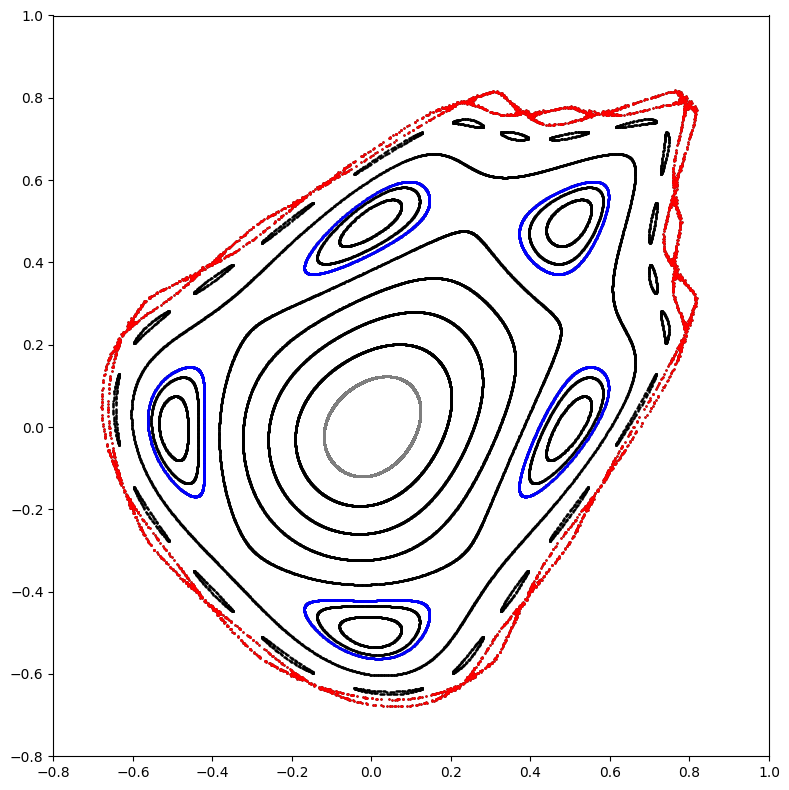

In [2]:
# Compute and plot several phase space trajectories

# gray -- regular trajectory near the origin
# blue -- regular resonant trajectory (frequency is close to a rational value and it is highly nonlinear
# red  -- chaotic trajectory

# Note, resonant trajectory being very nonlinear can be confused with a chaotic one
# In some sence it is OK to include them into a singe class

w = 0.5
q = numpy.linspace(0.1, 0.8, 11)
p = numpy.linspace(0.1, 0.7, 11)
qs, ps = orbit(2**12, w, q, p)

plt.figure(figsize=(8, 8))
plt.scatter(qs, ps, color='black', s=0.5)
plt.scatter(qs[0], ps[0], color='gray', s=0.5)
plt.scatter(qs[7], ps[7], color='blue', s=0.5)
plt.scatter(qs[-1], ps[-1], color='red', s=0.5)
plt.xlim(-0.8, 1.0)
plt.ylim(-0.8, 1.0)
plt.tight_layout()
plt.show()

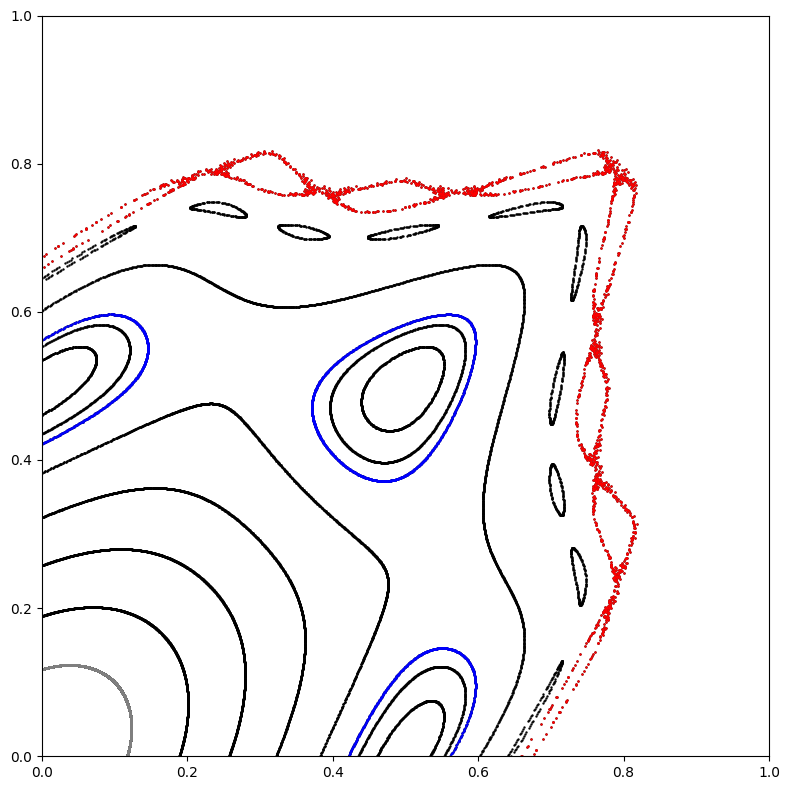

In [3]:
# Zoom

# Note, regular trajectories look one dimentional, while this is not true in chaotic case
# In fact, chaotic trajectory has fractional dimension

plt.figure(figsize=(8, 8))
plt.scatter(qs, ps, color='black', s=0.5)
plt.scatter(qs[0], ps[0], color='gray', s=0.5)
plt.scatter(qs[7], ps[7], color='blue', s=0.5)
plt.scatter(qs[-1], ps[-1], color='red', s=0.5)
plt.xlim(-0., 1.0)
plt.ylim(-0., 1.0)
plt.tight_layout()
plt.show()

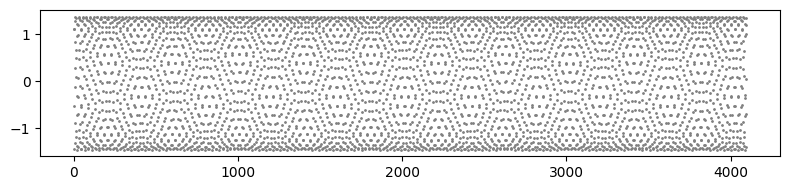

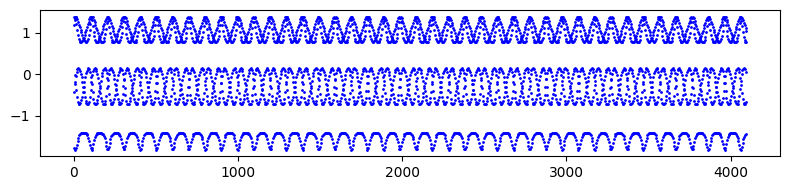

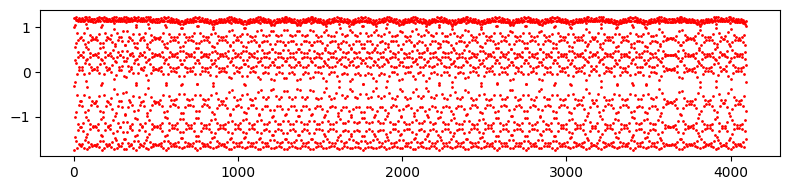

In [4]:
# Here are the same normalized trajectories vs iteration number
# Clearly, regular trajectories have more structure to them

plt.figure(figsize=(8, 2))
plt.scatter(range(2**12 + 1), (qs[0] - numpy.mean(qs[0]))/numpy.std(qs[0]), color='gray', s=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2))
plt.scatter(range(2**12 + 1), (qs[7] - numpy.mean(qs[7]))/numpy.std(qs[7]), color='blue', s=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2))
plt.scatter(range(2**12 + 1), (qs[-1] - numpy.mean(qs[-1]))/numpy.std(qs[-1]), color='red', s=1)
plt.tight_layout()
plt.show()

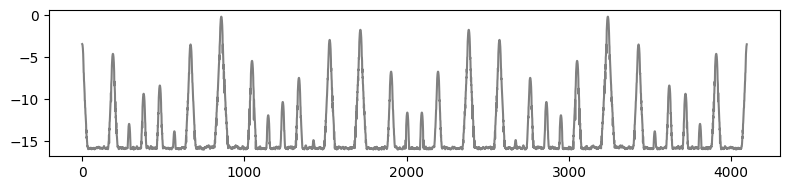

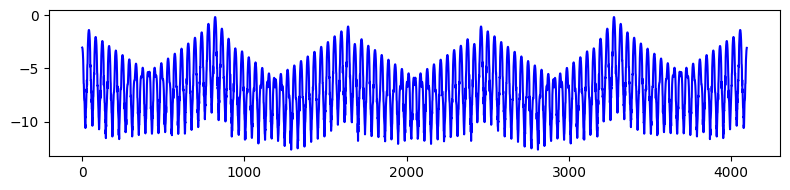

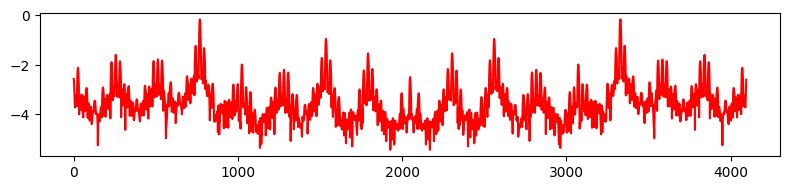

In [5]:
# Corresponding fourier amplitude spectra (with window)

f = window(2**12 + 1, 2.0)

plt.figure(figsize=(8, 2))
plt.errorbar(range(2**12 + 1), numpy.log10(1.0E-16 + numpy.abs(numpy.fft.fft(f*(qs[0] - numpy.mean(qs[0]))/numpy.std(qs[0])))), color='gray', ms=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2))
plt.errorbar(range(2**12 + 1), numpy.log10(1.0E-16 + numpy.abs(numpy.fft.fft(f*(qs[7] - numpy.mean(qs[7]))/numpy.std(qs[7])))), color='blue', ms=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2))
plt.errorbar(range(2**12 + 1),  numpy.log10(1.0E-16 + numpy.abs(numpy.fft.fft(f*(qs[-1] - numpy.mean(qs[-1]))/numpy.std(qs[-1])))), color='red', ms=1)
plt.tight_layout()
plt.show()

In [6]:
# Set grid for conventional classification method

w = 0.5
q = numpy.linspace(-0.8, 1., 5001)
p = numpy.linspace(-0.8, 1., 5001)

qp = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(5001*5001, -1)
qp.shape

(25010001, 2)

In [7]:
%%time

# Compute indicators for each initial value using 2**11 iterations
# Output is winsorized into [-16, 0]
# Indicator returns log10 of reverse distance

out = classify(2**11, w, qp)
out = out.reshape(5001, 5001)
out[out > 0.0] = 0.0
out[out < - 16.0] = -16.0

CPU times: user 3min 23s, sys: 60.2 ms, total: 3min 23s
Wall time: 12.9 s


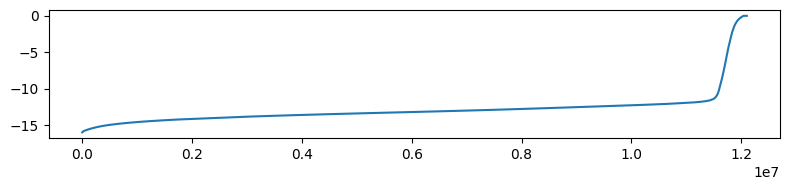

In [8]:
# Plot sorted indicator values for all stable initials (not nans after 2**11 iterations)
# The elbow indicates two different classes, there is also a transition region
# These values can be used as labels in supervised methods or a threshold can be set to get binary labels

plt.figure(figsize=(8, 2))
plt.plot(numpy.sort(out.flatten()))
plt.tight_layout()
plt.show()

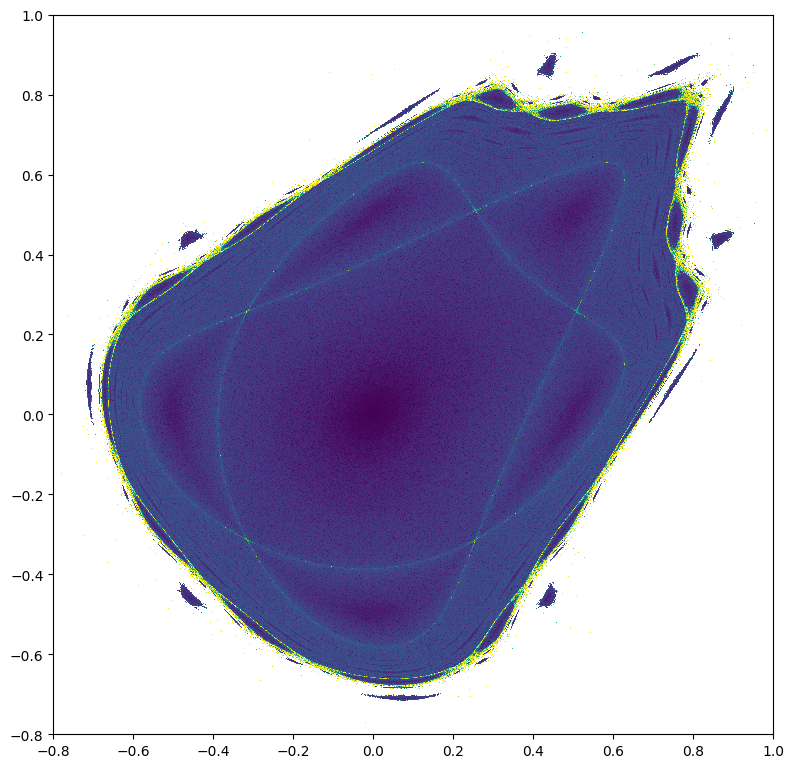

In [9]:
# Plot indicators
# Yellow region corresponds to chaotic trajectories

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(-0.8, 1, -0.8, 1))
plt.tight_layout()
plt.show()

In [10]:
# Set zoom grid

w = 0.5
q = numpy.linspace(0.55, 0.85, 5001)
p = numpy.linspace(0.55, 0.85, 5001)

qp = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(5001*5001, -1)
qp.shape

(25010001, 2)

In [11]:
%%time

# Compute and winsorize

out = classify(2**11, w, qp)
out = out.reshape(5001, 5001)
out[out > 0.0] = 0.0
out[out < - 16.0] = -16.0

CPU times: user 3min 24s, sys: 150 ms, total: 3min 24s
Wall time: 13.2 s


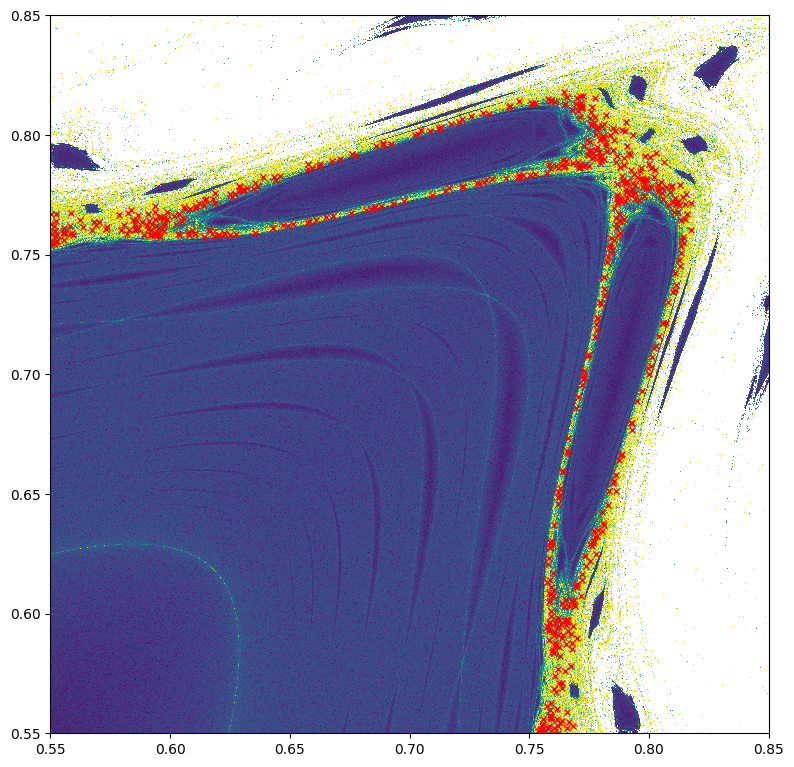

In [12]:
# Plot zoomed region along with a sample chaotic trajectory

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', origin='lower', cmap='viridis', interpolation='nearest', extent=(0.55, 0.85, 0.55, 0.85))
plt.errorbar(qs[-1], ps[-1], color='red', fmt=' ', ms=5, marker='x')
plt.xlim(0.55, 0.85)
plt.ylim(0.55, 0.85)
plt.tight_layout()
plt.show()